### Install libraries

In [ ]:
!pip install -q transformers[torch] datasets
!pip install simpletransformers
!pip install datasets
!pip install ipywidgets
!pip install --upgrade huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0

In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

## Import dataset

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pickle
with open("dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

train_dataset = dict_dataset['train']
val_dataset = dict_dataset['validation']
test_dataset = dict_dataset['test']

Mounted at /content/drive


In [ ]:
val_dataset

Dataset({
    features: ['text', 'label', 'domain', '__index_level_0__'],
    num_rows: 6769
})

In [ ]:
val_dataset['text']

['@miss_tattoo LOL! cuuuute! how did the M&amp;G go? Im sooo happy danny loved your book! I texted',
 'When you start seeing signs that he may be a girl or boy at this time, make sure to get in touch with your doctor for advice. Your pregnancy will only last about four months and there are some changes taking place as you progress through gestation. The more information you can have on these events during the first trimester, the better prepared youll feel when they happen!',
 'sneaked on :O Really dont wanna go to work, im scared theyll be mean and ruin my day. i want to play',
 '@waytobe what measure or controlling mechanism do you have to ensure that the quality of your sales is just as good as',
 'Just a question. Are hot air balloons a good choice for branding on #bing Mi Read More: http://is.',
 'aha! photos done studying.. not so sure who to send it to so Ill send it to you ;)',
 'If you notice any of these, its likely that you need to bring your pet in: Not sleeping well – your

# Models
Access trained models from Hugging Face Hub

In [ ]:
# Define transformers' initialization dictionary
transformer_models = ['albert_base_v2', 'ai-generated-text-classification']

In [ ]:
# Define a dictionary where each key matches its corresponding CNN model/transformer
classification_models = {}

In [ ]:
cnn_we_models = ['wiki100', 'twitter25', 'wiki300']

from tensorflow.keras.models import load_model
# Load the saved and already trained models
for model in cnn_we_models:
  classification_models[model] = {'model':load_model(f"{model}_model.h5"), 'is_transformer': False}

In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model in transformer_models:
  classification_models[model] = {'model': AutoModelForSequenceClassification.from_pretrained(f"luciayn/{model}").to(device), 'is_transformer': True}

In [ ]:
classification_models.keys()

dict_keys(['wiki100', 'twitter25', 'wiki300', 'albert_base_v2', 'ai-generated-text-classification'])

# Evaluation of each model on Validation Dataset


In [ ]:
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def get_prediction_transformer(text, max_length, tokenizer, model):
    # prepara el texto, aplicamos la misma tokenización que la utilizada en el training
    inputs = tokenizer(text, padding="max_length", max_length=max_length, truncation= True, return_tensors="pt").to(device)
    # aplicamos el modelo
    pred = model(**inputs).logits
    # obtenemos la probabilidad para cada clase
    probs = pred.softmax(1)
    # devolvemos la mayor
    return probs.argmax().item()

def get_prediction_cnn_we(dataset_name, model):
    tokenizer = Tokenizer(oov_token = True)
    # Train the tokenizer using the texts
    tokenizer.fit_on_texts(dict_dataset['train']['text'])
    max_length = 85
    # Use index 0 represents  token padding (all texts have same length)
    tokenizer.word_index['<PAD>'] = 0
    encoded_texts = tokenizer.texts_to_sequences(dict_dataset[dataset_name]['text'])
    encoded_texts_pad = pad_sequences(encoded_texts, maxlen=max_length, padding='post')
    # Storing the prediction outputs
    return np.argmax(model.predict(encoded_texts_pad), axis=1)

def compute_metrics(y_true, y_pred):
  precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
  acc = accuracy_score(y_true, y_pred)
  return {
      'accuracy': round(acc, 5),
      'f1': round(f1, 5),
      'precision': round(precision, 5),
      'recall': round(recall, 5)
  }

In [ ]:
# Models evaluation under the validation set
model_evaluation = {}
for model_name in list(classification_models.keys()):
  model_evaluation[model_name] = {}

  if classification_models[model_name]['is_transformer']==True:
    tokenizer = AutoTokenizer.from_pretrained(f"luciayn/{model_name}")
    max_length = max([len(tokenizer(text).input_ids) for text in dict_dataset['validation']['text']])
    # Storing the prediction outputs
    model_evaluation[model_name]['validation_predictions']=[get_prediction_transformer(text, max_length, tokenizer, classification_models[model_name]['model']) for text in dict_dataset['validation']['text']]

  else:
    # Storing the prediction outputs
    model_evaluation[model_name]['validation_predictions']=get_prediction_cnn_we('validation', classification_models[model_name]['model'])

  # True label values
  y_true = dict_dataset['validation']['label']
  # Storing the metrics
  model_evaluation[model_name]['metrics'] = compute_metrics(y_true, model_evaluation[model_name]['validation_predictions'])
  print(f"{model_name}\t", model_evaluation[model_name].get("metrics"))


212/212 [==============================] - 1s 4ms/step
wiki100	 {'accuracy': 0.6645, 'f1': 0.69676, 'precision': 0.63946, 'recall': 0.76533}
212/212 [==============================] - 1s 5ms/step
twitter25	 {'accuracy': 0.63215, 'f1': 0.69693, 'precision': 0.59559, 'recall': 0.83984}
212/212 [==============================] - 2s 5ms/step
wiki300	 {'accuracy': 0.66302, 'f1': 0.69808, 'precision': 0.63603, 'recall': 0.77354}
albert_base_v2	 {'accuracy': 0.92879, 'f1': 0.92928, 'precision': 0.92956, 'recall': 0.92901}


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

ai-generated-text-classification	 {'accuracy': 0.91535, 'f1': 0.90992, 'precision': 0.98035, 'recall': 0.84893}


# Ensembles
Create a dictionary containing each individual ensemble.

In [ ]:
import collections
from itertools import combinations

# Define a list containing the lists of models of each ensemble
models_names = list(classification_models.keys())
ensembles_list = list()

# Store the different combinations of models, starting from length 1 up to the total number of models (5 in our case)
for i in range(1, len(models_names) + 1):
    ensembles_list += list(combinations(models_names, i))
ensembles_list = [list(ensemble) for ensemble in ensembles_list]

# Define a dictionary with the ensembles
ensembles = {}
for i in range(len(ensembles_list)):
  ensembles["ensemble{:02d}".format(i)] = {}
  ensembles["ensemble{:02d}".format(i)]["models"] = ensembles_list[i]
  ensembles["ensemble{:02d}".format(i)]["metrics"] = {}
ensembles

{'ensemble00': {'models': ['wiki100'], 'metrics': {}},
 'ensemble01': {'models': ['twitter25'], 'metrics': {}},
 'ensemble02': {'models': ['wiki300'], 'metrics': {}},
 'ensemble03': {'models': ['albert_base_v2'], 'metrics': {}},
 'ensemble04': {'models': ['ai-generated-text-classification'], 'metrics': {}},
 'ensemble05': {'models': ['wiki100', 'twitter25'], 'metrics': {}},
 'ensemble06': {'models': ['wiki100', 'wiki300'], 'metrics': {}},
 'ensemble07': {'models': ['wiki100', 'albert_base_v2'], 'metrics': {}},
 'ensemble08': {'models': ['wiki100', 'ai-generated-text-classification'],
  'metrics': {}},
 'ensemble09': {'models': ['twitter25', 'wiki300'], 'metrics': {}},
 'ensemble10': {'models': ['twitter25', 'albert_base_v2'], 'metrics': {}},
 'ensemble11': {'models': ['twitter25', 'ai-generated-text-classification'],
  'metrics': {}},
 'ensemble12': {'models': ['wiki300', 'albert_base_v2'], 'metrics': {}},
 'ensemble13': {'models': ['wiki300', 'ai-generated-text-classification'],
  'me

In [ ]:
ensembles_list

[['wiki100'],
 ['twitter25'],
 ['wiki300'],
 ['albert_base_v2'],
 ['ai-generated-text-classification'],
 ['wiki100', 'twitter25'],
 ['wiki100', 'wiki300'],
 ['wiki100', 'albert_base_v2'],
 ['wiki100', 'ai-generated-text-classification'],
 ['twitter25', 'wiki300'],
 ['twitter25', 'albert_base_v2'],
 ['twitter25', 'ai-generated-text-classification'],
 ['wiki300', 'albert_base_v2'],
 ['wiki300', 'ai-generated-text-classification'],
 ['albert_base_v2', 'ai-generated-text-classification'],
 ['wiki100', 'twitter25', 'wiki300'],
 ['wiki100', 'twitter25', 'albert_base_v2'],
 ['wiki100', 'twitter25', 'ai-generated-text-classification'],
 ['wiki100', 'wiki300', 'albert_base_v2'],
 ['wiki100', 'wiki300', 'ai-generated-text-classification'],
 ['wiki100', 'albert_base_v2', 'ai-generated-text-classification'],
 ['twitter25', 'wiki300', 'albert_base_v2'],
 ['twitter25', 'wiki300', 'ai-generated-text-classification'],
 ['twitter25', 'albert_base_v2', 'ai-generated-text-classification'],
 ['wiki300', '

# Best Ensemble

The vote function determines the ensembler prediction based on the outcomes of its transformers. Its arguments are:

- predictions: list of transformers' (raw) outputs
- weighted: bool that determines if a weighted voting system must be used
- weights: list of weights (normalized F1-scores)

The predict_ensemble function calculates the predictions of each ensemble for a given dataset split (dataset_name, dataset).

Execute the predicted labels for each validation instance for each ensemble.

In [ ]:
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader

# Function which determines the ensembler prediction based on its transformers' predictions.
# A weighted voting system may be used
def vote(predictions, weighted=False, weights=None):
  voting = sum(predictions * weights) if weighted else sum(predictions)/len(predictions)
  return 0 if voting < 0.5 else 1

ensemble_evaluation = {}

# Function to predict the label of the instances in a dataset split (validation ("val") or test ("test")) for each ensemble
def predict_ensemble(ensemble_name, dataset_name, dataset, weighted=False):
  ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"] = list()
  # Traverse each dataset instance
  for i in range(len(DataLoader(dataset, shuffle=False))):
    predictions = list()
    ensemble_models = ensembles[ensemble_name].get("models")
    # Get the raw output of each model in the ensemble for the instance at hand
    for model_name in ensemble_models:
      curr_model_outputs = model_evaluation[model_name].get(f"{dataset_name}_predictions")
      predictions.append(curr_model_outputs[i])

    # Define the list of weights if a weighted voting system must be used
    weights = list()
    if weighted:
      # The weights' list is obtained by normalizing the F1-scores of the models in the ensemble
      f1_scores_list = [model_evaluation[model_name]["metrics"].get("f1")
                        for model_name in ensembles[ensemble_name].get("models")]
      weights = normalize([f1_scores_list], norm="l1")[0]

    # Append the predicted label to the predictions of the ensemble
    ensemble_pred = vote(predictions, weighted, weights)
    ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"].append(ensemble_pred)

# Ensembles' evaluation under the validation set
for ensemble_name in ensembles:
  ensemble_evaluation[ensemble_name] = {}
  ensemble_evaluation[ensemble_name]["validation_predictions"] = list()
  predict_ensemble(ensemble_name, "validation", dict_dataset['validation'], weighted=True) # weighted=False
  ensembles[ensemble_name]["metrics"] = compute_metrics(dict_dataset['validation']['label'], ensemble_evaluation[ensemble_name].get("validation_predictions"))
  print(f"{ensemble_name}\t", ensembles[ensemble_name].get("metrics"))

ensemble00	 {'accuracy': 0.6645, 'f1': 0.69676, 'precision': 0.63946, 'recall': 0.76533}
ensemble01	 {'accuracy': 0.63215, 'f1': 0.69693, 'precision': 0.59559, 'recall': 0.83984}
ensemble02	 {'accuracy': 0.66302, 'f1': 0.69808, 'precision': 0.63603, 'recall': 0.77354}
ensemble03	 {'accuracy': 0.92879, 'f1': 0.92928, 'precision': 0.92956, 'recall': 0.92901}
ensemble04	 {'accuracy': 0.91535, 'f1': 0.90992, 'precision': 0.98035, 'recall': 0.84893}
ensemble05	 {'accuracy': 0.63215, 'f1': 0.69693, 'precision': 0.59559, 'recall': 0.83984}
ensemble06	 {'accuracy': 0.66302, 'f1': 0.69808, 'precision': 0.63603, 'recall': 0.77354}
ensemble07	 {'accuracy': 0.92879, 'f1': 0.92928, 'precision': 0.92956, 'recall': 0.92901}
ensemble08	 {'accuracy': 0.91535, 'f1': 0.90992, 'precision': 0.98035, 'recall': 0.84893}
ensemble09	 {'accuracy': 0.66302, 'f1': 0.69808, 'precision': 0.63603, 'recall': 0.77354}
ensemble10	 {'accuracy': 0.92879, 'f1': 0.92928, 'precision': 0.92956, 'recall': 0.92901}
ensemble11	

In [ ]:
import json

# Save ensembles to JSON file
with open('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/ensembles_all.json', 'w', encoding='utf-8') as f:
    json.dump(ensembles, f, ensure_ascii=False, indent=4)

Given that it is a binary classification task, the best ensemble will be that with a maximum F1-score.

In [ ]:
# Defining a dictionary with the F1-score of each ensemble
f1_scores = {ensemble_name: ensembles[ensemble_name]["metrics"].get("f1") for ensemble_name in ensemble_evaluation}
# Selecting the best ensemble
best_ensemble_name = max(f1_scores, key=f1_scores.get)
best_ensemble = {"name": best_ensemble_name,
                 "models": ensembles[best_ensemble_name].get("models"),
                 "metrics": ensembles[best_ensemble_name].get("metrics")
                 }

best_ensemble

{'name': 'ensemble27',
 'models': ['wiki100',
  'twitter25',
  'albert_base_v2',
  'ai-generated-text-classification'],
 'metrics': {'accuracy': 0.93249,
  'f1': 0.93271,
  'precision': 0.93643,
  'recall': 0.92901}}

# Predictions on test set

In [ ]:
# Predicting the label of the test set's instances with each individual transformer
for model_name in models_names:
  if classification_models[model_name]['is_transformer']==True:
    tokenizer = AutoTokenizer.from_pretrained(f"luciayn/{model_name}")
    max_length = max([len(tokenizer(text).input_ids) for text in dict_dataset['validation']['text']])
    # Storing the prediction outputs
    model_evaluation[model_name]['test_predictions']=[get_prediction_transformer(text, max_length, tokenizer, classification_models[model_name]['model']) for text in dict_dataset['test']['text']]

  else:
    # Storing the prediction outputs
    model_evaluation[model_name]['test_predictions']=get_prediction_cnn_we('test', classification_models[model_name]['model'])

# Calculating the test predictions of the best ensemble
predict_ensemble(best_ensemble.get('name'), 'test', dict_dataset['test'], weighted=True) # weighted=False

683/683 [==============================] - 2s 2ms/step


In [ ]:
# Dump individual transformers' results
for model_name, evaluation in model_evaluation.items():
  # Converting ndarrays to lists
  model_evaluation[model_name]["validation_predictions"] = [int(pred) for pred in model_evaluation[model_name].get("validation_predictions")]
  model_evaluation[model_name]["test_predictions"] = [int(pred) for pred in model_evaluation[model_name].get("test_predictions")]

  os.makedirs(os.path.join('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en', model_name), exist_ok=True)
  with open(f'/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/{model_name}/model-evaluation.json', 'w', encoding='utf-8') as f:
    json.dump(model_evaluation[model_name], f, ensure_ascii=False, indent=4)

In [ ]:
# Complete fields of best ensemble dictionary
best_ensemble["validation_predictions"] = ensemble_evaluation[best_ensemble.get('name')].get("validation_predictions")
best_ensemble["test_predictions"] = ensemble_evaluation[best_ensemble.get('name')].get("test_predictions")

# Save best ensemble to JSON file
with open('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/best-ensemble_all.json', 'w', encoding='utf-8') as f:
    json.dump(best_ensemble, f, ensure_ascii=False, indent=4)

In [ ]:
import pandas as pd

# Convert the test dataset to a DataFrame
test_df = pd.DataFrame(dict_dataset['test'])

# Add a new column of predicted labels
test_df['predicted_label'] = ensemble_evaluation[best_ensemble.get('name')].get('test_predictions')

# Display the first 10 rows of the DataFrame
print(test_df.head(10))

                                                text  label   domain  \
0  It has remained one of my favorite country/swi...      1  reviews   
1  Even with very light use (hard to get motivate...      1  reviews   
2  She died in 2015 at age 93. She is survived by...      0     news   
3  Londonderry Crown Court heard how Heaney false...      1     news   
4  Will Genia, Lachie Turner and Berrick Barnes e...      1     news   
5  Im not even sure where to start. The plot is c...      0  reviews   
6  The right part came and was a day early, Chris...      1  reviews   
7  He was one of three victims who died following...      0     news   
8  This is very durable. This is very easy to ass...      0  reviews   
9  They raped numerous women at the stadium and t...      1     news   

   predicted_label  
0                1  
1                1  
2                0  
3                0  
4                1  
5                0  
6                1  
7                0  
8                0

In [ ]:
# Dump test predictions
test_df.to_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv', index=False)

## Classification report

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_true=test_df['label']
y_pred=test_df['predicted_label']

# Classification report
labels = ['Generated', 'Human']
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Generated       0.69      0.98      0.81     11190
       Human       0.96      0.54      0.69     10642

    accuracy                           0.77     21832
   macro avg       0.83      0.76      0.75     21832
weighted avg       0.82      0.77      0.75     21832



[[10943   247]
 [ 4868  5774]]


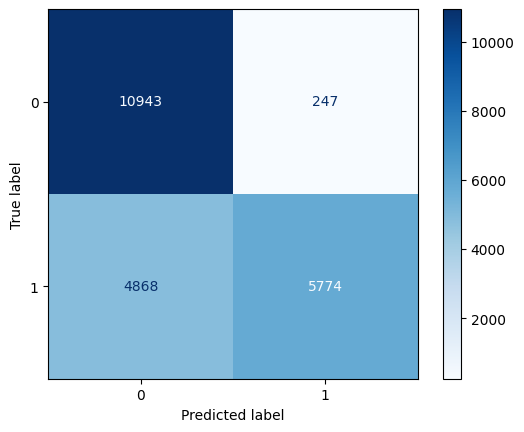

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_true, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)

<ipython-input-94-c1c7f8e62dd0>:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
<ipython-input-94-c1c7f8e62dd0>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve


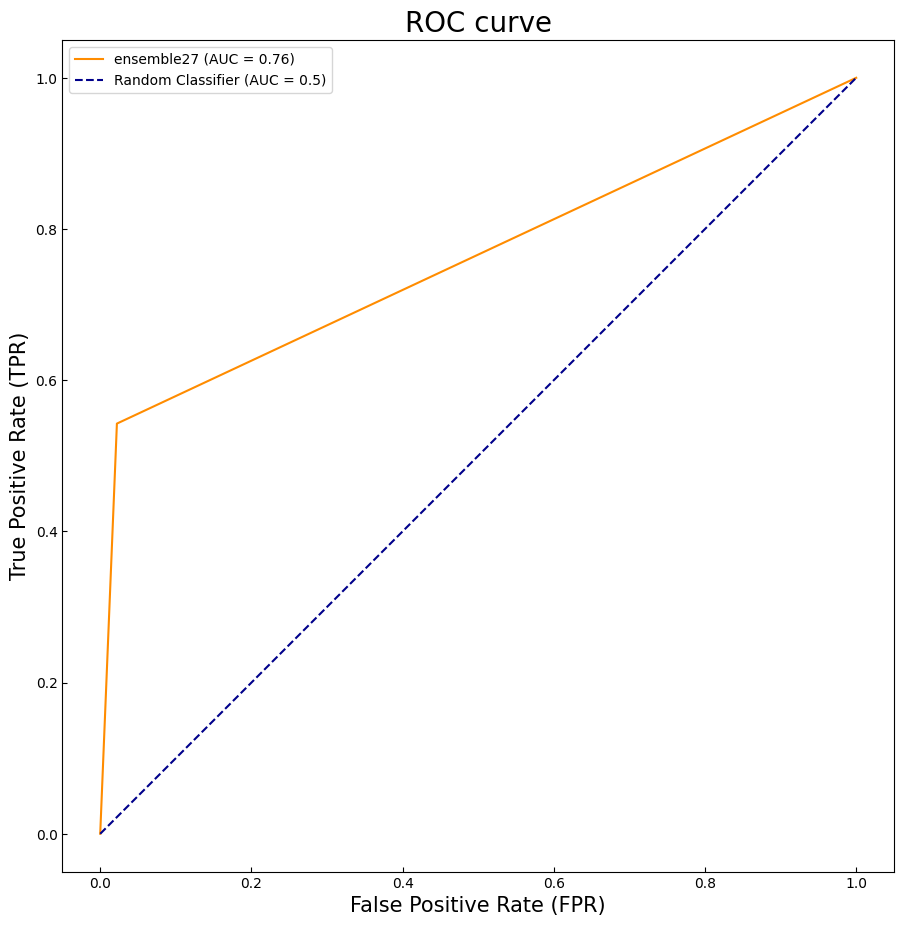

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig_roc = plt.figure(figsize = (10.8, 10.8))
fpr, tpr, _ = roc_curve(test_df["label"], test_df["predicted_label"])
plt.plot(fpr, tpr, color = "darkorange", label = "{} (AUC = {:0.2f})".format(best_ensemble.get("name"), auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
plt.axis("square")
plt.xlabel("False Positive Rate (FPR)", fontsize = 15)
plt.ylabel("True Positive Rate (TPR)", fontsize = 15)
plt.title("ROC curve", fontsize = 20)
plt.tick_params(axis = "y",direction = "in")
plt.tick_params(axis = "x",direction = "in")
plt.legend()

# # Save ROC curve
# fig_roc.savefig(os.path.join(PATH, "ROC.png"))
plt.show()

# Study of FN and FP

In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
predicted_texts = pd.read_csv('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/test-predictions_all.csv')
predicted_texts.head()

,text,label,domain,predicted_label
0,It has remained one of my favorite country/swi...,1,reviews,1
1,Even with very light use (hard to get motivate...,1,reviews,1
2,She died in 2015 at age 93. She is survived by...,0,news,0
3,Londonderry Crown Court heard how Heaney false...,1,news,0
4,"Will Genia, Lachie Turner and Berrick Barnes e...",1,news,1


In [ ]:
# Select 30 random FN texts: human texts classified as generated texts
random_fn_texts = predicted_texts[(predicted_texts['label']==1) & (predicted_texts['predicted_label']==0)].sample(30, random_state=7)
print(random_fn_texts['text'].values)

['But the sustainability of Moocs has come under question and a new generation of more carefully targeted distance learning courses have entered the arena. These postMooc courses are typically not as massive as Moocs, nor quite as open. And they are not only coming from the elite academic institutions of the West, but from ambitious techsavvy operators in emerging economies. For example, last month the Massachusetts Institute of Technology launched a 12week course in Future Commerce, with'
 'With this he can be out with his herd and it keeps him from gaining to much weight as well..The Velcro emergency release works well (he got it stuck on our gate once) but it doesnt fall off easy which is good. The buckles are sturdy and metal. Our last one used plastic and that lasted 2 months.My only negative is I found a better one with wider'
 'The area of land forms part of the Melness Crofting Estate near Tongue on the north Highland coast. HIE said it has also held talks with local residents 

In [ ]:
# Select 30 random FP texts: generated texts classified as human texts
random_fp_texts = predicted_texts[(predicted_texts['label']==0) & (predicted_texts['predicted_label']==1)].sample(30, random_state=7)
print(random_fp_texts['text'].values)

['The Slovenians then went ahead in the tie on aggregate when Damjan Bohars effort looped in off the post after 40 minutes. And the hosts finished off their remarkable turnaround in the second half, when Agim Ibraimi smashed in a penalty in the 58th minute after defender Olexandr Kucher was judged to have handled in the area. Ukraine have now lost five of their last six competitive games, while Maribor will face either Russia or'
 'The world number five will face either Switzerlands Timea Bacsinszky or American qualifier Bethanie MattekSands in the last 16. Konta has not dropped a set in her three matches so far in Eastbourne and has now won seven of her last eight matches. She said: Im obviously sorry to hear of Taras injury and wish her a speedy recovery. Im just grateful for the opportunity to play again and Im very'
 'If youre looking for a solid collection of standells songs,this might be your goto.However,if you are looking for some old standells hits,then dont buy this one.Thank

# Zipf Law

In [ ]:
import collections
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

def generate_zipf_table(text, top):

    """
    Create a list of dictionaries containing the top
    most frequent words, their frequencies and
    other Zipfian data.
    """

    text = _remove_punctuation(text)

    text = text.lower()

    words = _clean_text(text)

    top_word_frequencies = _top_word_frequencies(words, top)

    zipf_table = _create_zipf_table(top_word_frequencies)

    return zipf_table


def _remove_punctuation(text):

    """
    Removes the characters:
    !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789
    from the text.
    """

    chars_to_remove = "!\"#$%&’'()*+,-./:;<=>?@[\]^_`{|}~0123456789"

    tr = str.maketrans("", "", chars_to_remove)

    return text.translate(tr)


def _clean_text(text):

    """
    Eliminate stopwords, apply stemming, and
    delete words with length lower than 3, and
    returns list of tokens
    """
    # tokenize
    tokens=word_tokenize(text)

    # eliminate stopwords
    stopwords_en = stopwords.words("english")
    tokens = [word for word in tokens if word not in stopwords_en]

    # apply stemming
    tokens = [PorterStemmer().stem(word) for word in tokens]

    # eliminate words with length lower than 3
    min_length = 3

    # stored clean tokens
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length:
            filtered_tokens.append(token)

    return tokens


def _top_word_frequencies(words, top):   # top: max number of items to return

    """
    Create a list of tuples containing the most
    frequent words and their frequencies
    in descending order.
    """

    # Create a collections.Counter instance from an
    # iterable, in this case our list of words.
    word_frequencies = collections.Counter(words)

    # most_common() gives us a list of tuples
    # containing words and their frequencies,
    # in descending order of frequency.
    top_word_frequencies = word_frequencies.most_common(top)

    return top_word_frequencies


def _create_zipf_table(frequencies):

    """
    Takes the list created by _top_word_frequencies
    and inserts it into a list of dictionaries,
    along with the Zipfian data.
    """

    zipf_table = []

    top_frequency = frequencies[0][1]

    for index, item in enumerate(frequencies, start=1):

        relative_frequency = "1/{}".format(index)
        zipf_frequency = top_frequency * (1 / index)
        difference_actual = item[1] - zipf_frequency
        difference_percent = (item[1] / zipf_frequency) * 100

        zipf_table.append({"word": item[0],
                           "actual_frequency": item[1],
                           "relative_frequency": relative_frequency,
                           "zipf_frequency": zipf_frequency,
                           "difference_actual": difference_actual,
                           "difference_percent": difference_percent})

    return zipf_table


def print_zipf_table(zipf_table):

    """
    Prints the list created by generate_zipf_table
    in table format with column headings.
    """

    width = 80

    print("-" * width)
    print("|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|")
    print("-" * width)

    format_string = "|{:4}|{:12}|{:12.0f}|{:>12}|{:12.2f}|{:12.2f}|{:7.2f}%|"

    for index, item in enumerate(zipf_table, start=1):

        print(format_string.format(index,
                                   item["word"],
                                   item["actual_frequency"],
                                   item["relative_frequency"],
                                   item["zipf_frequency"],
                                   item["difference_actual"],
                                   item["difference_percent"]))

    print("-" * width)


def plot_zipf_law(zipf_table, title):
    ranks = np.arange(1, len(zipf_table) + 1)
    frequencies = [item['actual_frequency'] for item in zipf_table]
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker="o", linestyle='none')
    plt.title(title)
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--------------------------------------------------------------------------------
|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|
--------------------------------------------------------------------------------
|   1|said        |        3279|         1/1|     3279.00|        0.00| 100.00%|
|   2|book        |        2686|         1/2|     1639.50|     1046.50| 163.83%|
|   3|use         |        2602|         1/3|     1093.00|     1509.00| 238.06%|
|   4|also        |        2595|         1/4|      819.75|     1775.25| 316.56%|
|   5|one         |        2500|         1/5|      655.80|     1844.20| 381.21%|
|   6|would       |        2345|         1/6|      546.50|     1798.50| 429.09%|
|   7|like        |        2329|         1/7|      468.43|     1860.57| 497.19%|
|   8|product     |        2214|         1/8|      409.88|     1804.12| 540.16%|
|   9|great       |        2113|         1/9|      364.33|     1748.67| 579.96%|
|  10|time        |        1

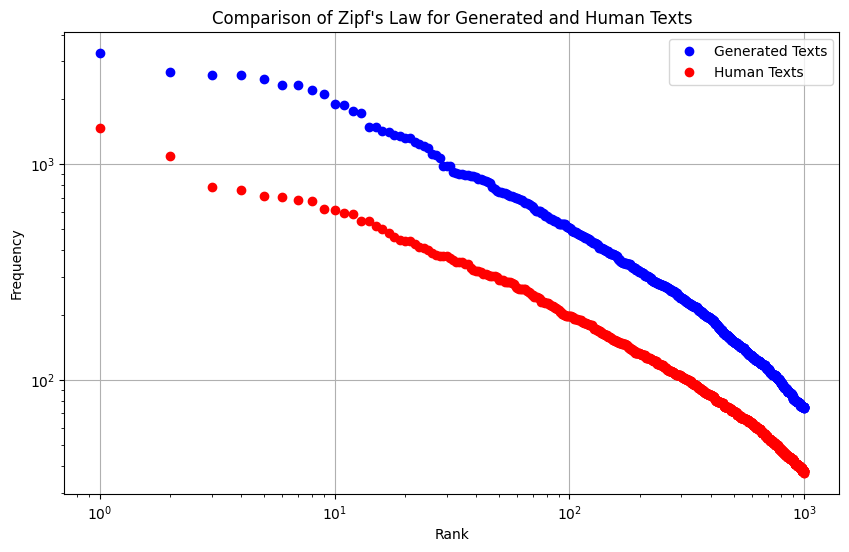

In [ ]:
def plot_zipf_law(zipf_table, title, color):
    ranks = np.arange(1, len(zipf_table) + 1)
    frequencies = [item['actual_frequency'] for item in zipf_table]
    plt.loglog(ranks, frequencies, marker="o", linestyle='none', label=title, color=color)

def compare_zipf_laws(zipf_table1, zipf_table2, label1, label2):
    plt.figure(figsize=(10, 6))
    plot_zipf_law(zipf_table1, label1, 'blue')
    plot_zipf_law(zipf_table2, label2, 'red')
    plt.title("Comparison of Zipf's Law for Generated and Human Texts")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming predicted_texts is a DataFrame with 'text', 'label', and 'predicted_label' columns
# Generate Zipf's table for generated texts
texts_generated = predicted_texts['text'][(predicted_texts['label'] == 0) & (predicted_texts['predicted_label'] == 0)]
text_generated = '\n'.join(texts_generated)
zipf_table_generated = generate_zipf_table(text_generated, 1000)
print_zipf_table(zipf_table_generated)

# Generate Zipf's table for human texts
texts_human = predicted_texts['text'][(predicted_texts['label'] == 1) & (predicted_texts['predicted_label'] == 1)]
text_human = '\n'.join(texts_human)
zipf_table_human = generate_zipf_table(text_human, 1000)
print_zipf_table(zipf_table_human)

# Compare Zipf's Laws
compare_zipf_laws(zipf_table_generated, zipf_table_human, "Generated Texts", "Human Texts")

In [ ]:
def compare_zipf_tables(zipf_table1, zipf_table2):
    words1 = set(item['word'] for item in zipf_table1)
    words2 = set(item['word'] for item in zipf_table2)
    common_words = words1.intersection(words2)
    return common_words

# Assuming zipf_table1 and zipf_table2 are the Zipf tables to be compared
common_words = compare_zipf_tables(zipf_table_generated, zipf_table_human)
print(f"Number of common Words: {len(common_words)}")


Number of common Words: 843
